In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Import các thư viện cần thiết**

In [26]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


**2. Đọc file dữ liệu GAS và chia dataset theo tỉ lệ 6:3:1**

In [27]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/GAS.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

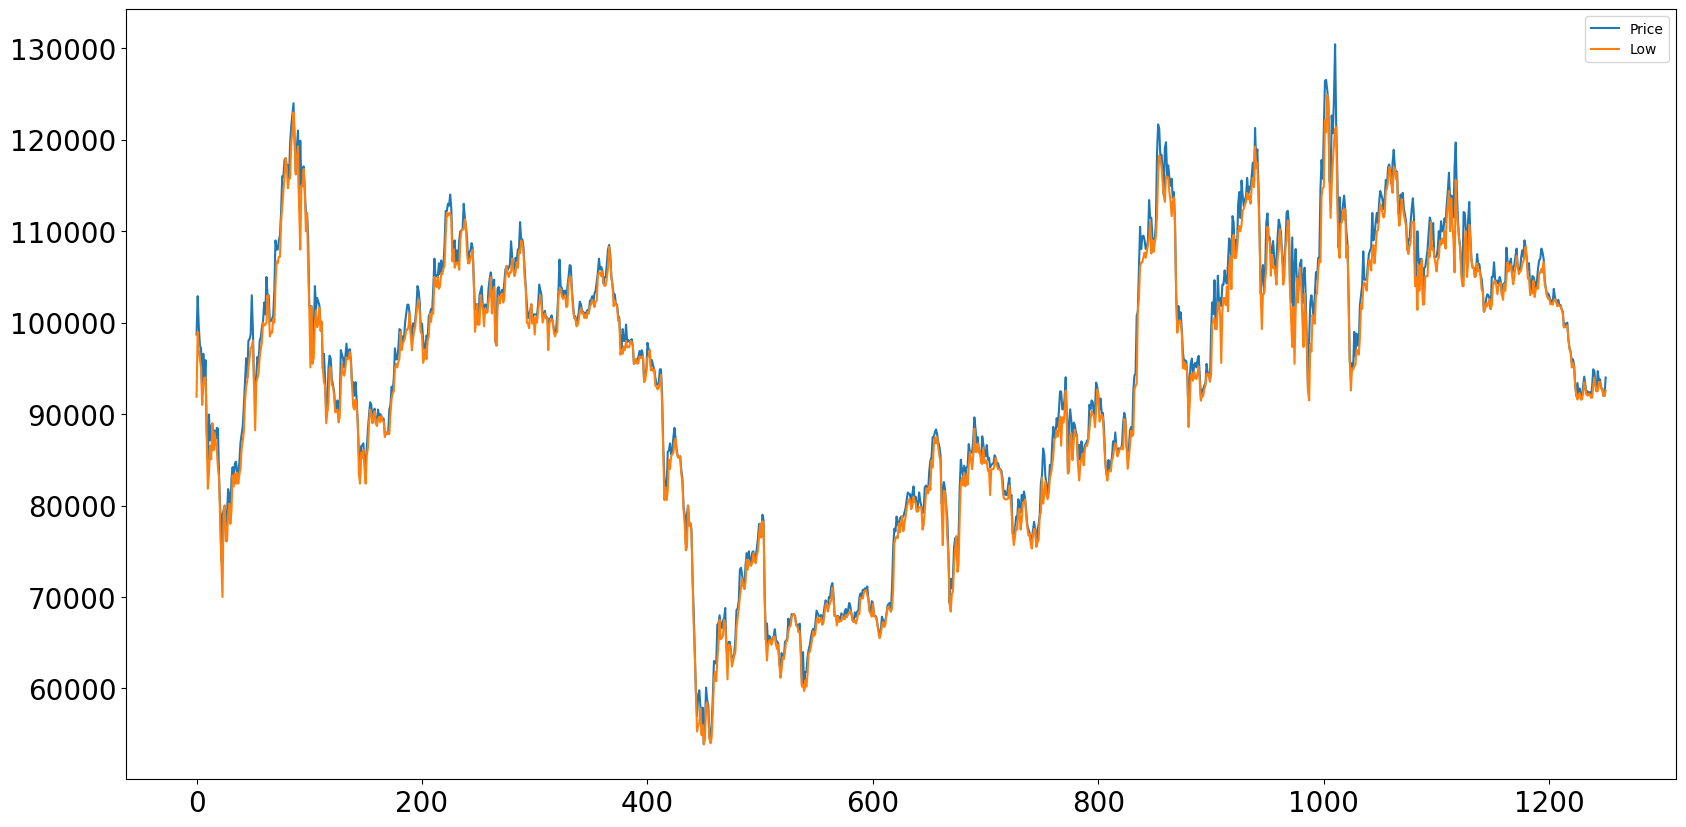

In [28]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [29]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-2.522927436736302,
 0.10999502002631956,
 8,
 1242,
 {'1%': -3.4356260602190356,
  '5%': -2.863869899335344,
  '10%': -2.5680104683371323},
 22241.436855014457)

In [30]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [31]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-26.51243545513257,
 0.0,
 1,
 1248,
 {'1%': -3.4356006420838963,
  '5%': -2.8638586845641063,
  '10%': -2.5680044958343604},
 22228.127821913695)

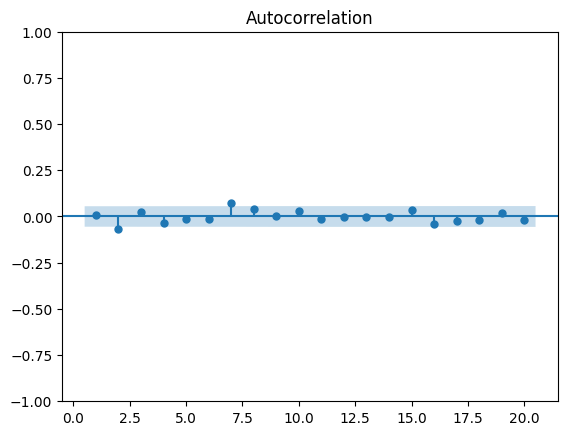

In [32]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [33]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
df

,Price,Low
0,98700,91900.0
1,102900,99000.0
2,99600,97000.0
3,97500,96000.0
4,97200,95100.0
...,...,...
1246,92900,92800.0
1247,92800,92800.0
1248,92000,92000.0
1249,92000,92000.0


In [35]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=13391.102, Time=2.66 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=13421.440, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=13413.995, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=13413.322, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=13419.541, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=13407.216, Time=3.29 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=13407.408, Time=3.82 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=inf, Time=8.32 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=13411.254, Time=13.75 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=13421.871, Time=0.71 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=13417.742, Time=4.07 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=13409.012, Time=8.07 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=13408.530, Time=4.34 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=13414.295, Time=1.29 sec
 ARIMA(2,1,1)(1,0,1)[5] 

**Dùng SARIMAX để train model**

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(2,1,2), seasonal_order=(1, 0, 1, 5))
model_fit = model1.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [43]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([ 83041.,  80210.,  81154.,  82664.,  81248.,  80682.,  81343.,
        83041.,  83513.,  84457.,  85400.,  87288.,  87382.,  88231.,
        87571.,  88609.,  89741.,  86540.,  89655.,  89071.,  90044.,
        92575.,  89557.,  83522.,  83717.,  87513.,  87903.,  84982.,
        86734.,  88292.,  87611.,  87611.,  84398.,  82743.,  84496.,
        85080.,  85664.,  84398.,  86150.,  86637.,  86540.,  87124.,
        88195.,  89460.,  90336.,  90044.,  89752.,  88584.,  90434.,
        92673.,  91991.,  89168.,  89557.,  89947.,  89655.,  87319.,
        84885.,  83522.,  82743.,  83717.,  83814.,  83717.,  84885.,
        85274.,  86248.,  86832.,  86345.,  85372.,  85761.,  86150.,
        86248.,  86442.,  86150.,  89460.,  89265.,  86442.,  84009.,
        85274.,  86442.,  88195.,  87611.,  87805.,  92770.,  93062.,
        93354., 101239., 102699., 106106., 106593., 106593., 107177.,
       107664., 107080., 107761., 108540., 109319., 110973., 107566.,
       109027., 1077

**5. Quá trình validate**

In [44]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
exg = np.array(val_data['Low'])
y_pred_val = model_fit.predict(start=len(x_train), end = len(x_train)+ len(y_val)-1, exog=exg)
y_pred_val

array([108900., 110000., 105000., 106500., 110700., 109000., 106800.,
       106000., 106000., 105000., 105100., 106500., 105600., 105800.,
       105200., 103600., 103500., 101200., 101500., 102100., 101800.,
       102200., 102600., 101500., 101900., 104000., 104500., 104600.,
       104000., 103100., 104100., 104200., 104400., 103000., 102500.,
       104200., 103500., 105100., 106600., 105600., 106000., 106400.,
       105200., 104200., 105000., 106200., 107300., 106100., 105300.,
       105600., 105700., 106400., 106700., 107300., 108300., 106900.,
       104800., 105000., 103000., 103400., 103200., 104600., 102800.,
       103600., 103900., 103700., 105300., 105500., 105900., 105500.,
       106600., 104200., 103700., 102900., 102600., 102700., 102000.,
       102100., 102000., 102400., 102600., 102400., 101800., 102000.,
       101800., 101800., 101400., 101000.,  99500.,  99500.,  99600.,
        99700.,  98100.,  97100.,  96700.,  95100.,  95600.,  95200.,
        93100.,  920

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [45]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[49646.55261921 49603.68913104 49560.82564287 49517.9621547
 49475.09866653 49432.23517836 49389.37169019 49346.50820202
 49303.64471385 49260.78122568 49217.91773751 49175.05424934
 49132.19076117 49089.327273   49046.46378483 49003.60029666
 48960.73680849 48917.87332032 48875.00983215 48832.14634398
 48789.28285581 48746.41936764 48703.55587947 48660.6923913
 48617.82890313 48574.96541496 48532.10192679 48489.23843862
 48446.37495046 48403.51146229]


***7.Đánh giá độ chính xác thuật toán***

In [46]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 1075.4843869934375
Testing RMSE: 2614.13254547915
Validation MAPE: 0.6551337853080632
Testing MAPE: 1.6384549277862543
Validation MAE: 682.5396825396765
Testing MAE: 1734.9813333333261


**8. Vẽ biểu đồ**

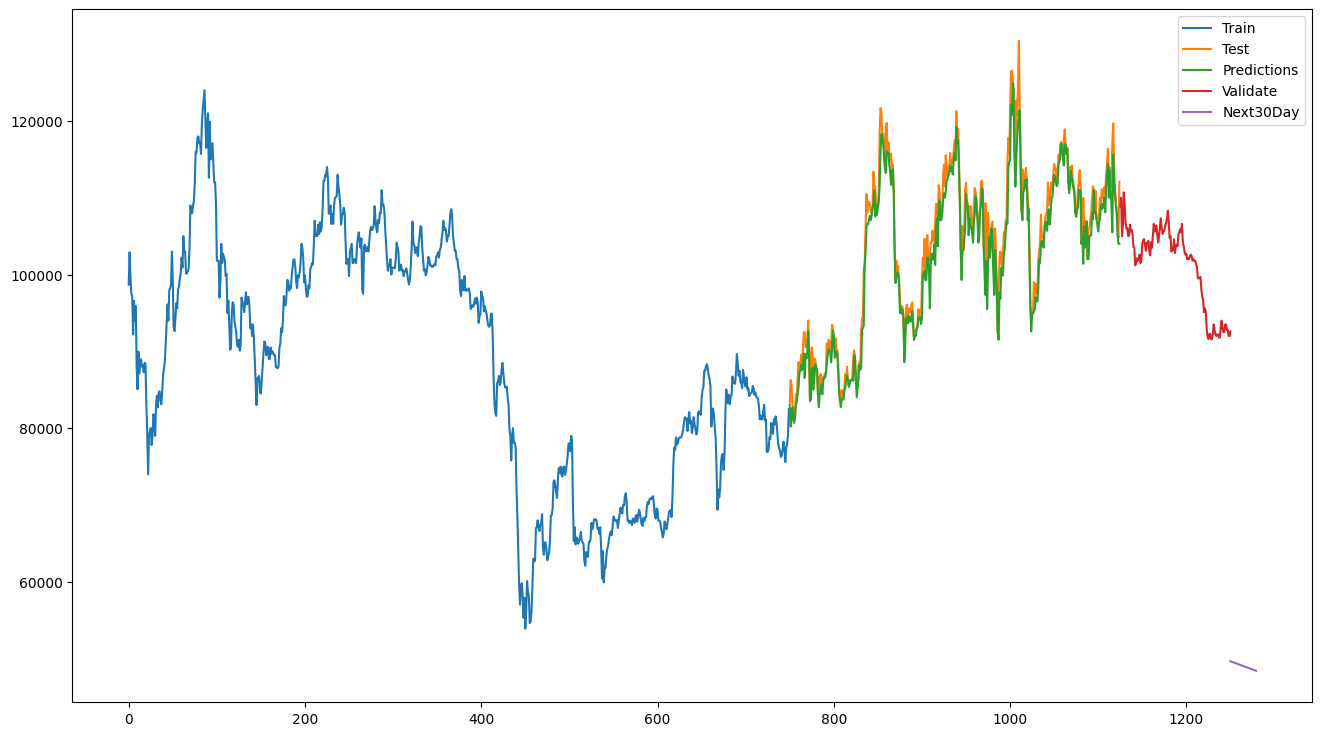

In [47]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()